In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from os import listdir
from os.path import isfile, join
from functools import reduce
from pathlib import Path

In [2]:
# Set figure size
rcParams['figure.figsize'] = (4, 4)

In [3]:
# Folder for images
Path("img").mkdir(parents=True, exist_ok=True)

# Data description

I have a Polar watch that tracks my vitals during workouts. I used the [Polar Flow](polar.flow.com) website to obtain a copy of my data.

In [4]:
path = "/home/dev/Desktop/Polar"

We create a list of files in the download.

In [5]:
files = [f for f in listdir(path) if isfile(join(path, f))]

We only consider files containing the string `'trainig-session'`.

In [6]:
files = [f for f in files if 'training-session' in f]

The number of files under consideration is:

In [7]:
len(files)

284

We loop over each of the files and them to a list.

In [8]:
data = []

for f in files:
    with open(join(path, f)) as f:
        d = json.load(f)
        data.append(d)

We extract the relevant information from the items in the list.

In [9]:
workouts = []

for d in data:
    workouts.append(d['exercises'][0])

Finally we create a dataframe containing the workout information.

In [10]:
df = pd.DataFrame(workouts)

# Data structure

We find the following columns in the dataframe.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startTime       284 non-null    object 
 1   stopTime        284 non-null    object 
 2   timezoneOffset  284 non-null    int64  
 3   duration        284 non-null    object 
 4   sport           284 non-null    object 
 5   kiloCalories    283 non-null    float64
 6   heartRate       283 non-null    object 
 7   zones           284 non-null    object 
 8   samples         284 non-null    object 
 9   distance        130 non-null    float64
 10  latitude        130 non-null    float64
 11  longitude       130 non-null    float64
 12  ascent          120 non-null    float64
 13  descent         121 non-null    float64
 14  speed           130 non-null    object 
 15  autoLaps        102 non-null    object 
 16  laps            2 non-null      object 
dtypes: float64(6), int64(1), object(10)

We remove columns that containt data from features I do not use in my training.

Due to privacy concerns I shan't be extracting longitudinal and latitudinal data.

In [12]:
df = df.drop(['zones', 'samples', 'autoLaps', 
              'laps', 'latitude', 'longitude'], axis=1)

In [13]:
df.head()

,startTime,stopTime,timezoneOffset,duration,sport,kiloCalories,heartRate,distance,ascent,descent,speed
0,2019-05-24T13:18:14.000,2019-05-24T14:58:44.125,120,PT6030.125S,STRENGTH_TRAINING,658.0,"{'min': 72, 'avg': 105, 'max': 136}",NaN,NaN,NaN,NaN
1,2019-05-04T12:03:34.000,2019-05-04T13:21:38.500,120,PT4684.500S,STRENGTH_TRAINING,373.0,"{'min': 71, 'avg': 99, 'max': 138}",NaN,NaN,NaN,NaN
2,2019-04-12T12:48:57.000,2019-04-12T12:59:10.750,120,PT613.750S,TREADMILL_RUNNING,62.0,"{'min': 71, 'avg': 97, 'max': 107}",NaN,NaN,NaN,NaN
3,2019-06-12T13:13:09.000,2019-06-12T13:23:15.500,120,PT606.500S,TREADMILL_RUNNING,71.0,"{'min': 67, 'avg': 105, 'max': 121}",NaN,NaN,NaN,NaN
4,2019-05-24T14:59:06.000,2019-05-24T15:29:08.750,120,PT1802.750S,TREADMILL_RUNNING,416.0,"{'min': 84, 'avg': 144, 'max': 170}",NaN,NaN,NaN,NaN


# Missing Values

In [14]:
missing = (df.isna().sum() / df.shape[0] * 100)
missing.name = 'Missing %'
missing = missing.to_frame()
missing = missing.sort_values('Missing %', ascending=False)
missing = missing[missing['Missing %'] > 0]
np.round(missing, 2)

,Missing %
ascent,57.75
descent,57.39
distance,54.23
speed,54.23
kiloCalories,0.35
heartRate,0.35


# Transforms

We apply certain transforms to make the data easier to work with. First we convert string to datetimes.

In [15]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['stopTime'] = pd.to_datetime(df['stopTime'])

We calculate the total duration of each individual workout in minutes.

In [16]:
df['totalTime'] = (df['stopTime'] - df['startTime'])
df['totalTime'] = df['totalTime'].apply(lambda x: round(x.seconds / 60, 2))
df.drop('duration', axis=1, inplace=True)

We split the datetime columns in to date and time.

In [17]:
df['startDate'] = pd.to_datetime(df['startTime']).dt.date
df['stopDate'] = pd.to_datetime(df['stopTime']).dt.date
df['startTime'] = pd.to_datetime(df['startTime']).dt.time
df['stopTime'] = pd.to_datetime(df['stopTime']).dt.time

We extract maximum, average and minimum heart rate values from the `heartRate` column.

In [18]:
df['heartRateMax'] = df['heartRate'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df['heartRateAvg'] = df['heartRate'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['heartRateMin'] = df['heartRate'].apply(lambda x: x['min'] if isinstance(x, dict) else np.nan)
df.drop('heartRate', axis=1, inplace=True)

In a similar manner we extract the maximum, average and minimum values form the `speed` column.

In [19]:
df['speedAvg'] = df['speed'].apply(lambda x: x['avg'] if isinstance(x, dict) else np.nan)
df['speedMax'] = df['speed'].apply(lambda x: x['max'] if isinstance(x, dict) else np.nan)
df.drop('speed', axis=1, inplace=True)

We reorder the data as follows.

In [20]:
order = ['startDate',
         'stopDate',
         'startTime',
         'stopTime',
         'timezoneOffset',
         'totalTime', 
         'sport',
         'kiloCalories',
         'heartRateMax',
         'heartRateAvg',
         'heartRateMin']

In [21]:
df = df[order]

We check if there are any more `NaN`'s in the data.

In [22]:
df.isna().sum()

startDate         0
stopDate          0
startTime         0
stopTime          0
timezoneOffset    0
totalTime         0
sport             0
kiloCalories      1
heartRateMax      1
heartRateAvg      1
heartRateMin      1
dtype: int64

There is one row with `NaN`'s. This might due to my watch having little battery left to make the measurements.

In [23]:
df = df.dropna()

Finally we proceed to sort the data with the latest workouts at the top of the dataframe.

In [24]:
sort_cols = ['startDate','startTime']
df = df.sort_values(sort_cols, ascending=False)
df = df.reset_index(drop=True)

In [25]:
df.head()

,startDate,stopDate,startTime,stopTime,timezoneOffset,totalTime,sport,kiloCalories,heartRateMax,heartRateAvg,heartRateMin
0,2020-03-29,2020-03-29,21:50:21,22:23:41.750000,120,33.33,WALKING,245.0,116.0,102.0,69.0
1,2020-03-27,2020-03-27,20:38:32,21:25:03.750000,60,46.52,WALKING,401.0,132.0,104.0,70.0
2,2020-03-26,2020-03-26,21:07:46,21:52:55.625000,60,45.15,WALKING,336.0,122.0,103.0,87.0
3,2020-03-25,2020-03-25,19:22:38,20:10:17.875000,60,47.65,WALKING,380.0,125.0,108.0,87.0
4,2020-03-24,2020-03-24,13:09:06,13:48:46.750000,60,39.67,WALKING,358.0,141.0,117.0,90.0


# Basic analysis

Given that we have produced a clean dataset we can proceed to visualize a few aspect.

## Total kilocalories
First we count the total kilocalories I burned during the period in question.

In [26]:
total_calories = df['kiloCalories'].sum()
print(total_calories)

89421.0


## Daily burned kilocalories
Next we produce a plot of kilocalories burned over time.

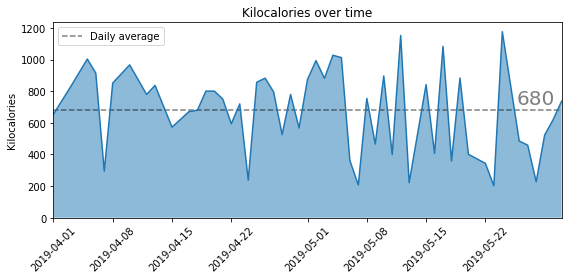

In [27]:
width = 800
height = 400
dpi = 100

start = pd.to_datetime('2019-04-1') 
stop = pd.to_datetime('2019-06-1')

daily = df[['startDate', 'kiloCalories']]
mask = (daily['startDate'] >= start) & (daily['startDate'] < stop)
daily = daily[mask]
daily = daily.groupby('startDate', as_index=False)
daily = daily.sum()
daily = daily.sort_values('startDate', ascending=False)
daily = daily.reset_index(drop=True)

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(daily['startDate'], daily['kiloCalories'])

plt.fill_between(x=daily['startDate'], 
                 y1=0, 
                 y2=daily['kiloCalories'], 
                 alpha=1/2)

plt.hlines(xmin=daily['startDate'].min(),
           xmax=daily['startDate'].max(),
           y=daily['kiloCalories'].mean(),
           linestyle='dashed',
           label='Daily average',
           alpha=1/2)

plt.text(x=daily.loc[3, 'startDate'],
         y=daily['kiloCalories'].mean() + 75,
         s=round(daily['kiloCalories'].mean()),
         verticalalignment='center',
         horizontalalignment='center',
         alpha=1/2,
         fontsize=20)

plt.title('Kilocalories over time')
plt.xticks(rotation=45, horizontalalignment='center')
plt.xlim(daily['startDate'].min(), daily['startDate'].max())
plt.ylim(0, daily['kiloCalories'].max() * 1.05)
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./img/kilocalories_ts.png')
plt.show()

## Activity counts

We can check how many workouts I completed.

In [28]:
stats = df[['sport', 'startTime']]
stats = stats.groupby(['sport'], as_index=False)
stats = stats.count()
stats = stats.rename(columns={'sport': 'Sport', 
                              'startTime': 'Count'})
stats = stats.sort_values('Count', ascending=False)
stats.head()

,Sport,Count
4,WALKING,105
3,TREADMILL_RUNNING,90
2,STRENGTH_TRAINING,62
0,CYCLING,24
1,RUNNING,2


## Walk plots

We plot `totalTime` versus `kiloCalories`. As can be seen their seems to exist a linear relationship between the two.

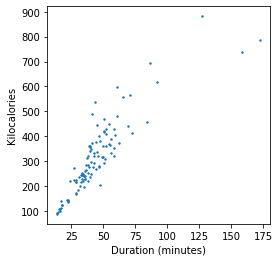

In [29]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['totalTime'], walking['kiloCalories'], s=2)
plt.xlabel('Duration (minutes)')
plt.ylabel('Kilocalories')
plt.savefig('./img/kilocalories_vs_time.png')
plt.show()

We plot `heartRateAvg` against `kiloCalories`. Again we see a linear relationship although there are a couple of outliers

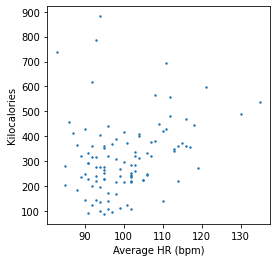

In [30]:
walking = df[df['sport'] == 'WALKING']
plt.scatter(walking['heartRateAvg'], walking['kiloCalories'], s=2)
plt.ylabel('Kilocalories')
plt.xlabel('Average HR (bpm)')
plt.savefig('./img/kilocalories_vs_avg_hr.png')
plt.show()